In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as tgrad
import torch.nn.functional as F


import os
import time
import tqdm
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from timeit import default_timer as timer

import importlib
import utils
import networks

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams.update({'font.size': 16})

In [3]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
# torch.set_default_tensor_type(torch.DoubleTensor)
print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

True
cuda


# The Black Scholes Formula
The Black–Scholes formula calculates the price of European put and call options. This price is consistent with the Black–Scholes equation. This follows since the formula can be obtained by solving the equation for the corresponding terminal and boundary conditions:
$$    

    {\begin{aligned}&C(0,t)=0{\text{ for all }}t\\&C(S,t)\rightarrow S-K{\text{ as }}S\rightarrow \infty \\&C(S,T)=\max\{S-K,0\}\end{aligned}}

    $$

The value of a call option for a non-dividend-paying underlying stock in terms of the Black–Scholes parameters is:

$$
    {\begin{aligned}C(S_{t},t)&=N(d_{+})S_{t}-N(d_{-})Ke^{-r(T-t)}\\d_{+}&={\frac {1}{\sigma {\sqrt {T-t}}}}\left[\ln \left({\frac {S_{t}}{K}}\right)+\left(r+{\frac {\sigma ^{2}}{2}}\right)(T-t)\right]\\d_{-}&=d_{+}-\sigma {\sqrt {T-t}}\\\end{aligned}}
    $$

The price of a corresponding put option based on put–call parity with discount factor $e^{{-r(T-t)}}$ is:
$$
    {\begin{aligned}P(S_{t},t)&=Ke^{-r(T-t)}-S_{t}+C(S_{t},t)\\&=N(-d_{-})Ke^{-r(T-t)}-N(-d_{+})S_{t}\end{aligned}}\,
    $$

In [13]:
S = torch.Tensor([80]).requires_grad_()
t = torch.Tensor([0]).requires_grad_()
sigma = torch.Tensor([0.3]).requires_grad_()
r = torch.Tensor([0.05]).requires_grad_()
K = torch.Tensor([70])
T = torch.Tensor([1])
t2m = T-t
d1 = (torch.log(S / K) + (r + 0.5 * sigma**2) * t2m)/(sigma * torch.sqrt(t2m))
d2 = d1 - sigma * torch.sqrt(t2m)
N0 = lambda value: 0.5 * (1 + torch.erf((value/2**0.5)))
Nd1 = N0(d1)
Nd2 = N0(d2)
C = S* Nd1 - K* Nd2 *torch.exp(-r*t2m)
print("Option Price:", C.item()) #17.01496

Option Price: 17.01496124267578


# The Black Scholes Equation
The gradient is calculated using the auto gradient method in pytorch.

$$
{\frac {\partial V}{\partial t}}+{\frac {1}{2}}\sigma ^{2}S^{2}{\frac {\partial ^{2}V}{\partial S^{2}}}+rS{\frac {\partial V}{\partial S}}-rV=0
$$

To check the correctness of the calculation, it uses the Greeks equation from the Black-Scholes Formula.

In [14]:
dCdt, = tgrad.grad(C, t, grad_outputs=torch.ones(C.shape), create_graph=True, only_inputs=True)
dCdS, = tgrad.grad(C, S, grad_outputs=torch.ones(C.shape), create_graph=True, only_inputs=True)
d2CdS2, = tgrad.grad(dCdS, S, grad_outputs=torch.ones(dCdS.shape), create_graph=True, only_inputs=True)
dCdvol, = tgrad.grad(C, sigma, grad_outputs=torch.ones(C.shape), create_graph=True, only_inputs=True)

dCdr, = tgrad.grad(C, r, grad_outputs=torch.ones(C.shape), create_graph=True, only_inputs=True)
theta, delta, gamma, vega, rho = -dCdt[0], dCdS[0], d2CdS2[0], dCdvol[0], dCdr[0]

print(f'{theta.item():.4f}', f'{delta.item():.4f}', f'{gamma.item():.4f}', f'{vega.item():.4f}', f'{rho.item():.4f}')
# Theta 5.8385 Delta 0.7769 Gamma 0.0124 Vega 23.8776 Rho 45.1372

5.8385 0.7769 0.0124 23.8776 45.1372


# Data Sampling
Here in our case, the system is European Call Option PDE and the physical information about the system consists of Boundary Value conditions, final Value conditions and the PDE itself.

In [4]:
K = 10
r = 0.035
sigma = 0.2
T = 1
S_range = [0, int(5*K)]
t_range = [0, T]
gs = lambda x: np.fmax(x-K, 0)
M = 100
N = 5000

In [5]:
samples = {"pde": 5000, "bc":500, "fc":500}

bc_st_train, bc_v_train, n_st_train, n_v_train = \
    utils.trainingData(K, r, sigma, T, S_range[-1], S_range, t_range, gs, 
                       samples['bc'], 
                       samples['fc'], 
                       samples['pde'], 
                       RNG_key=123)

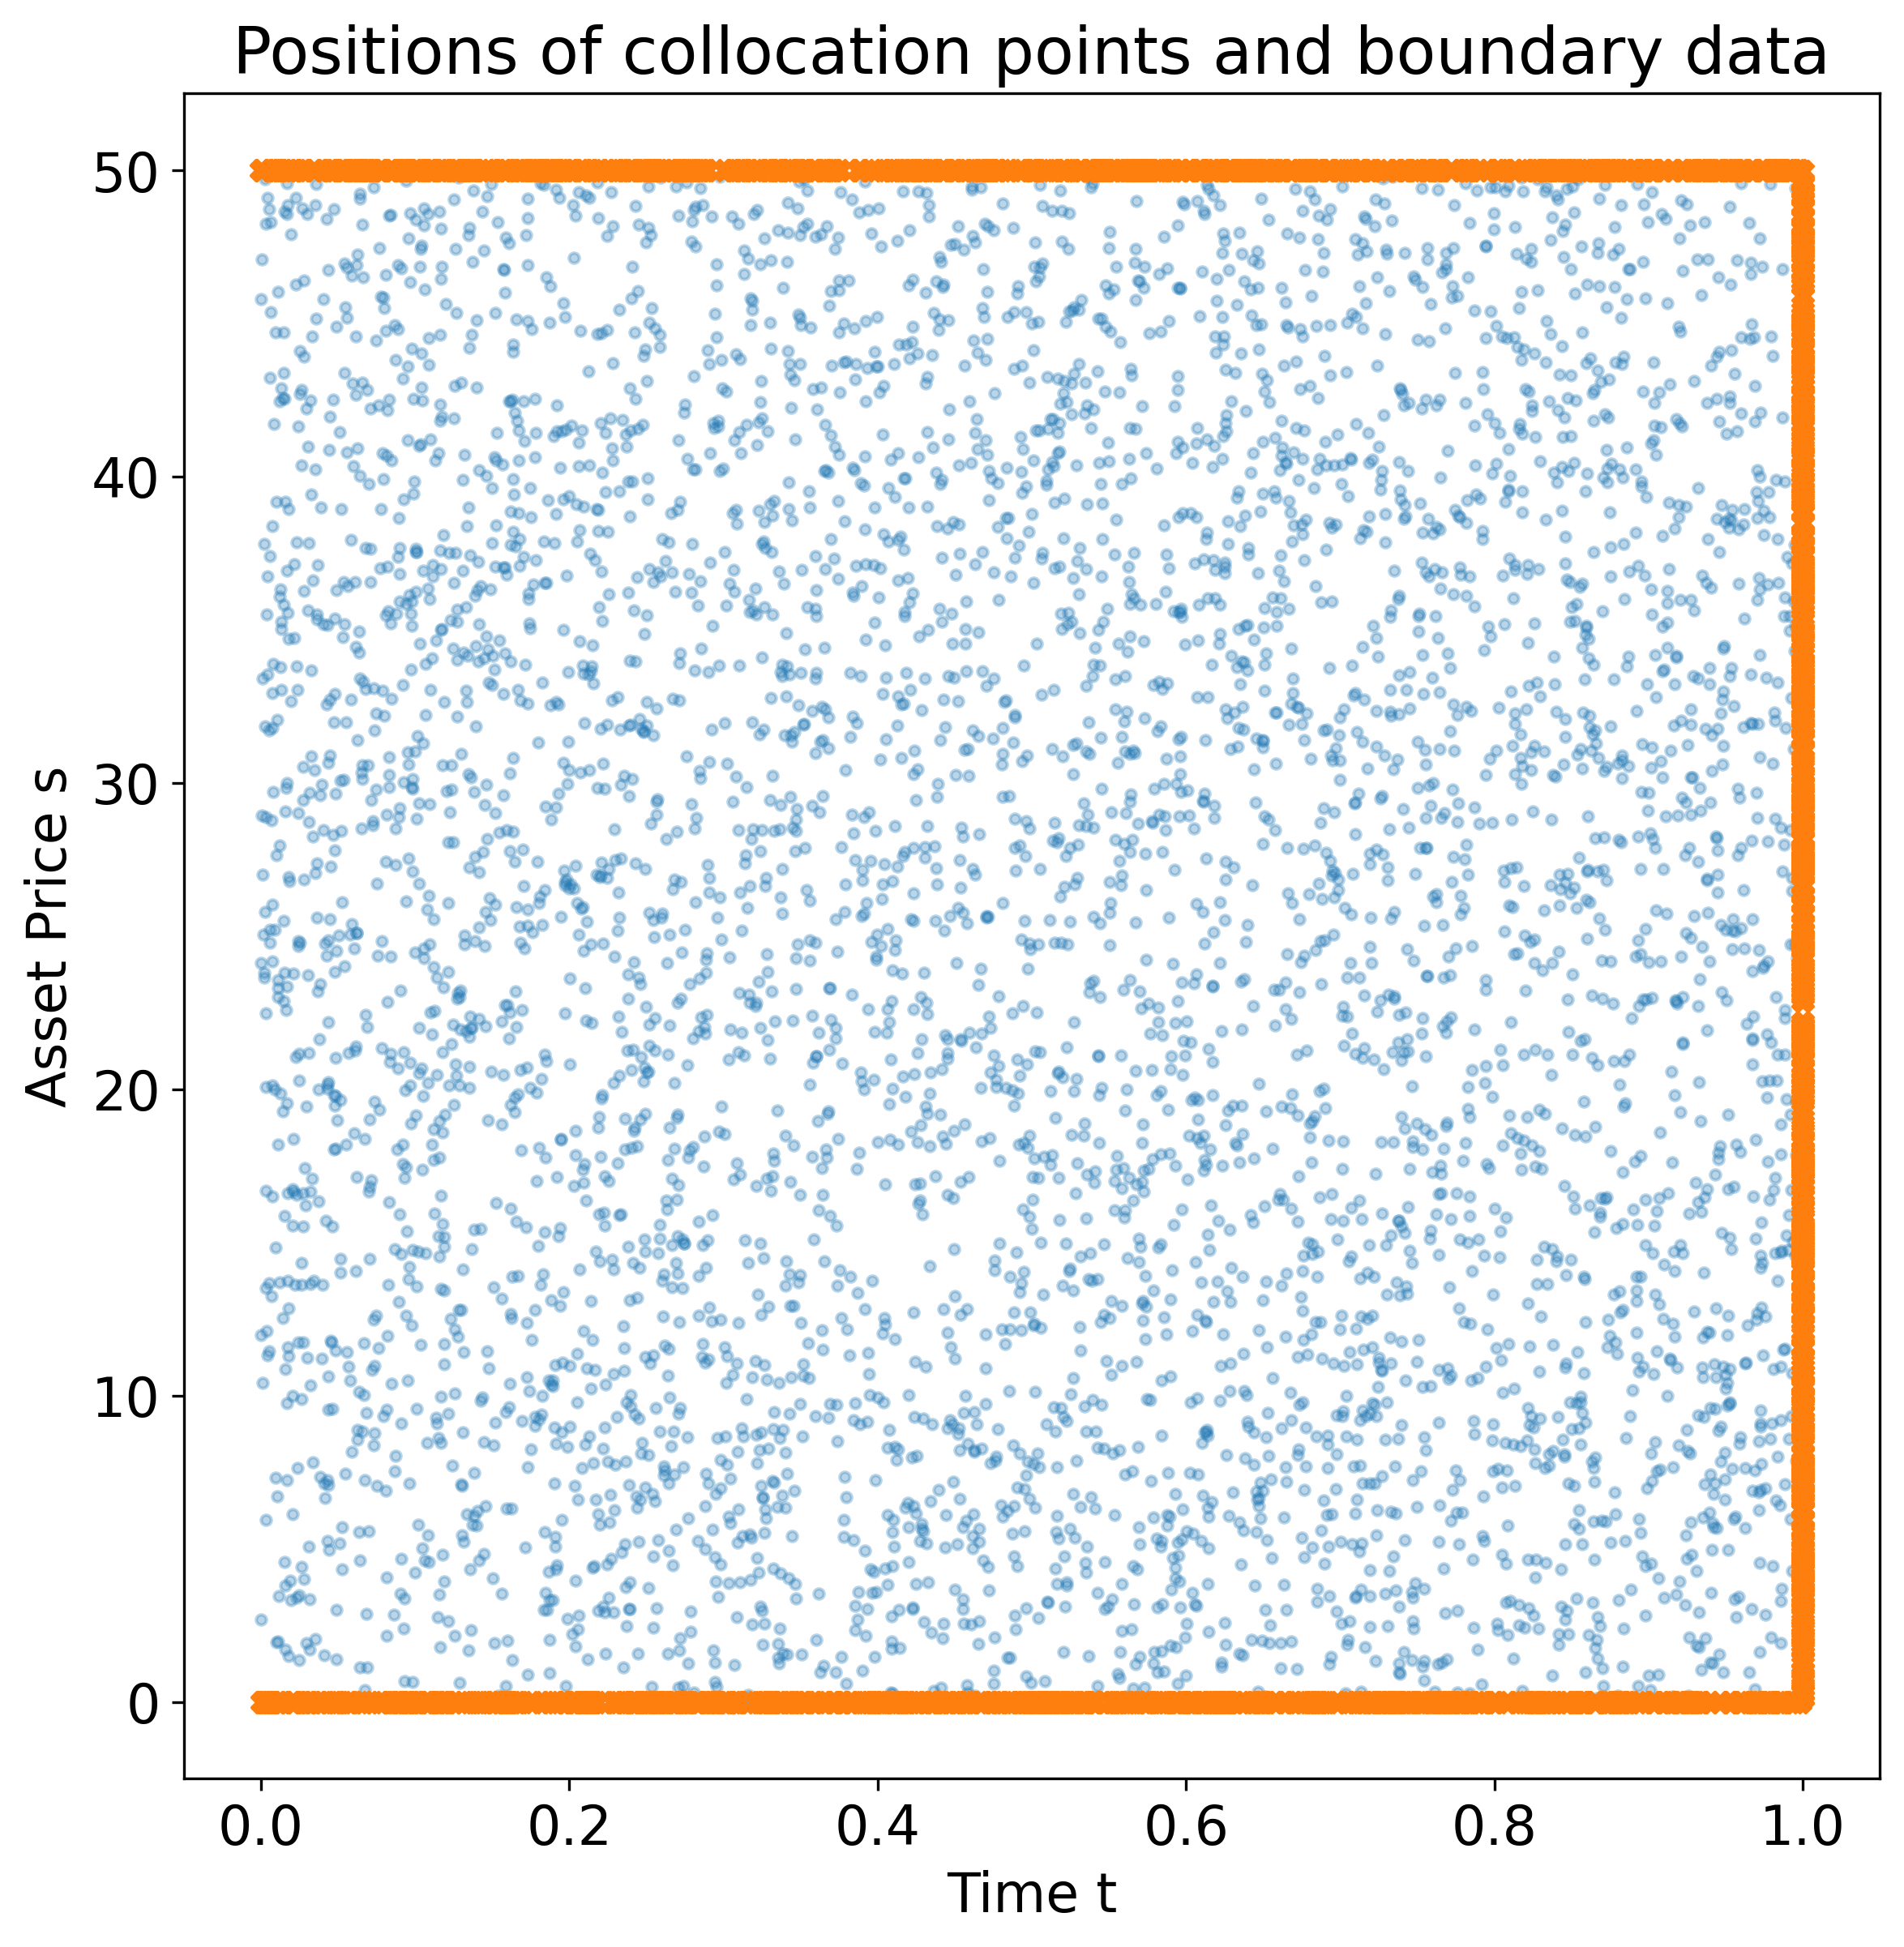

In [7]:
fig = plt.figure(figsize=(9,9))
plt.scatter([sublist[0] for sublist in n_st_train], [sublist[1] for sublist in n_st_train], marker='.',alpha=0.3)
plt.scatter([sublist[0] for sublist in bc_st_train], [sublist[1] for sublist in bc_st_train], marker='X')
plt.xlabel('Time t')
plt.ylabel('Asset Price s')

plt.title('Positions of collocation points and boundary data');

In [18]:
# sample data generated by finite difference method
X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = utils.fdm_data(S_range[-1], T, M, N, "500000sample.csv", device)

# Hyperparameters


In [19]:
n_epochs = 20000
lossFunction = nn.MSELoss()
sizes=[2, 50, 50, 50, 50, 50, 50, 50, 50, 1]
lr = 3e-5
activation = 'relu'
optimizer = 'adam'
loss_weights = [1, 1, 1]

# Test Error

In [20]:
model1 = networks.FeedforwardNeuralNetwork(2, 50, 1, 8)
model1.to(device)
model1.load_state_dict(torch.load('default/pinn.pth'))
model1.eval()
prediction = model1(X_test_tensor)
print(lossFunction(prediction, y_test_tensor).item())

0.001480627222917974


In [21]:
model1.load_state_dict(torch.load('default/awpinn.pth'))
model1.eval()
prediction = model1(X_test_tensor)
print(lossFunction(prediction, y_test_tensor).item())

0.001633001258596778


In [22]:
model1.load_state_dict(torch.load('default/nn.pth'))
model1.eval()
prediction = model1(X_test_tensor)
print(lossFunction(prediction, y_test_tensor).item())

3.207471308996901e-05


In [23]:
sizes=[2, 50, 50, 50, 50, 50, 50, 50, 50, 1]
model2 = networks.ImprovedNeuralNetwork(sizes, 'relu', 0, 0.1, 10.0)
model2.to(device)
model2.load_state_dict(torch.load('default/ipinn.pth'))
model2.eval()
prediction = model2(X_test_tensor)
print(lossFunction(prediction, y_test_tensor).item())

0.001865991740487516


In [24]:
model2.load_state_dict(torch.load('default/awipinn.pth'))
model2.eval()
prediction = model2(X_test_tensor)
print(lossFunction(prediction, y_test_tensor).item())

0.001837603049352765


# PINN vs IPINN vs AWPINN

In [25]:
pinn, loss_list, min_model = utils.network_training(
    K, r, sigma, T, S_range[-1], S_range, t_range, gs, samples['bc'], samples['fc'], samples['pde'], RNG_key=123,
    device=device, net='pinn', opt=optimizer, sizes=sizes, activation=activation, learning_rate=lr, n_epochs=n_epochs, lossFunction=lossFunction, dropout_rate=0, adaptive_rate=None, adaptive_rate_scaler=0, loss_weights=loss_weights, adaptive_weight=None, X_train_tensor=X_train_tensor, y_train_tensor=y_train_tensor,
    )

torch.save(min_model, "default/pinn.pth")  # Save the model's state dictionary
# Save the training loss history as a CSV file
loss_df = pd.DataFrame(loss_list)
loss_df.to_csv('default/pinn_loss.csv', index=False)

[Training procedure]: 100%|##########| 20000/20000 [07:00<00:00, 47.56it/s]


In [26]:
ipinn, loss_list2, min_model = utils.network_training(
    K, r, sigma, T, S_range[-1], S_range, t_range, gs, samples['bc'], samples['fc'], samples['pde'], RNG_key=123,
    device=device, net='ipinn', opt=optimizer, sizes=sizes, activation=activation, learning_rate=lr, n_epochs=n_epochs, lossFunction=lossFunction, dropout_rate =0, adaptive_rate=0.1, adaptive_rate_scaler=10.0, loss_weights=loss_weights, adaptive_weight=None, X_train_tensor=X_train_tensor, y_train_tensor=y_train_tensor,
    )

torch.save(min_model, "default/ipinn.pth")  # Save the model's state dictionary
# Save the training loss history as a CSV file
loss_df = pd.DataFrame(loss_list2)
loss_df.to_csv('default/ipinn_loss.csv', index=False)

[Training procedure]: 100%|##########| 20000/20000 [11:38<00:00, 28.65it/s]


In [27]:
awpinn, loss_list4, min_model = utils.network_training(
    K, r, sigma, T, S_range[-1], S_range, t_range, gs, samples['bc'], samples['fc'], samples['pde'], RNG_key=123,
    device=device, net='pinn', opt=optimizer, sizes=sizes, activation=activation, learning_rate=lr, n_epochs=n_epochs, lossFunction=lossFunction, dropout_rate=0, adaptive_rate=None, adaptive_rate_scaler=0, loss_weights=loss_weights, adaptive_weight=True, X_train_tensor=X_train_tensor, y_train_tensor=y_train_tensor,
    )

torch.save(min_model, "default/awpinn.pth")  # Save the model's state dictionary
# Save the training loss history as a CSV file
loss_df = pd.DataFrame(loss_list4)
loss_df.to_csv('default/awpinn_loss.csv', index=False)

[Training procedure]: 100%|##########| 20000/20000 [08:21<00:00, 39.87it/s]


In [28]:
awipinn, loss_list5, min_model = utils.network_training(
    K, r, sigma, T, S_range[-1], S_range, t_range, gs, samples['bc'], samples['fc'], samples['pde'], RNG_key=123,
    device=device, net='ipinn', opt=optimizer, sizes=sizes, activation=activation, learning_rate=lr, n_epochs=n_epochs, lossFunction=lossFunction, dropout_rate=0, adaptive_rate=0.1, adaptive_rate_scaler=10.0, loss_weights=loss_weights, adaptive_weight=True, X_train_tensor=X_train_tensor, y_train_tensor=y_train_tensor,
    )

torch.save(min_model, "default/awipinn.pth")  # Save the model's state dictionary
# Save the training loss history as a CSV file
loss_df = pd.DataFrame(loss_list5)
loss_df.to_csv('default/awipinn_loss.csv', index=False)

[Training procedure]: 100%|##########| 20000/20000 [11:39<00:00, 28.59it/s]


In [29]:
import datetime
net = networks.FeedforwardNeuralNetwork(2, 50, 1, 8)
net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-5)
loss_hist6 = []
logging.info(f'{net}\n')
logging.info(f'Training started at {datetime.datetime.now()}\n')
min_train_loss = float("inf")  # Initialize with a large value
final_model = None
start_time = timer()
for _ in tqdm.tqdm(range(n_epochs), desc='[Training procedure]', ascii=True, total=n_epochs):
    prediction = net(X_train_tensor)
    loss = lossFunction(prediction, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_hist6.append(loss.item())
    
    if loss.item() < min_train_loss:
        min_train_loss = loss.item()
        final_model = net.state_dict()
    pass

torch.save(final_model, "default/nn.pth")  # Save the model's state dictionary
# Save the training loss history as a CSV file
loss_df = pd.DataFrame(loss_hist6)
loss_df.to_csv('default/nn_loss.csv', index=False)

[Training procedure]: 100%|##########| 20000/20000 [04:03<00:00, 82.18it/s]


## PINN with Different Loss weights

In [20]:
weights = [[0.5, 0.25, 0.25], [0.25, 0.5, 0.25], [0.25, 0.25, 0.5], [0.7, 0.15, 0.15], [0.15, 0.7, 0.15], [0.15, 0.15, 0.7]]

In [21]:
models = []
loss_hists_lists = []
n_epochs = 5000

# train models with different weights
for i in range(len(weights)):
    w1 = weights[i][0]
    w2 = weights[i][1]
    w3 = weights[i][2]
    wpinn, loss_list, min_model = utils.network_training(
        K, r, sigma, T, S_range[-1], S_range, t_range, gs, samples['bc'], samples['fc'], samples['pde'], RNG_key=123,
        device=device, net='pinn', opt='adam', sizes=sizes, activation='relu', learning_rate=lr, n_epochs=n_epochs, 
        lossFunction=lossFunction, dropout_rate=None, adaptive_rate=None, adaptive_rate_scaler=None, loss_weights=weights[i], adaptive_weight=None, X_train_tensor=X_train_tensor, y_train_tensor=y_train_tensor,
        )
    torch.save(wpinn.state_dict(), f"pinn-weight-test/pinn-{w1}-{w2}-{w3}.pth")  # Save the model's state dictionary
    # Save the training loss history as a CSV file
    loss_df = pd.DataFrame(loss_list)
    loss_df.to_csv(f'pinn-weight-test/pinn-{w1}-{w2}-{w3}_loss.csv', index=False)
    pass

[Training procedure]: 100%|##########| 5000/5000 [01:11<00:00, 69.93it/s]


# IPINN with Different loss weights

In [22]:
models = []
loss_hists_lists = []

# train models with different weights
for i in range(len(weights)):
    w1 = weights[i][0]
    w2 = weights[i][1]
    w3 = weights[i][2]
    wpinn, loss_list, min_model = utils.network_training(
        K, r, sigma, T, S_range[-1], S_range, t_range, gs, samples['bc'], samples['fc'], samples['pde'], RNG_key=123,
        device=device, net='ipinn', opt='adam', sizes=sizes, activation='relu', learning_rate=lr, n_epochs=n_epochs, 
        lossFunction=lossFunction, dropout_rate=0, adaptive_rate=0.1, adaptive_rate_scaler=10.0, loss_weights=weights[i], adaptive_weight=None, X_train_tensor=X_train_tensor, y_train_tensor=y_train_tensor,
        )
    torch.save(wpinn.state_dict(), f"ipinn-weight-test/ipinn-{w1}-{w2}-{w3}.pth")  # Save the model's state dictionary
    # Save the training loss history as a CSV file
    loss_df = pd.DataFrame(loss_list)
    loss_df.to_csv(f'ipinn-weight-test/ipinn-{w1}-{w2}-{w3}_loss.csv', index=False)
    pass



[Training procedure]: 100%|##########| 5000/5000 [01:46<00:00, 46.90it/s]
